In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import minmax_scale, StandardScaler
import matplotlib
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils import data
from sklearn.model_selection import train_test_split

### Getting sample from 3D block as vertical drill hole

Text(0.5, 1.0, 'Drill holes - plan view')

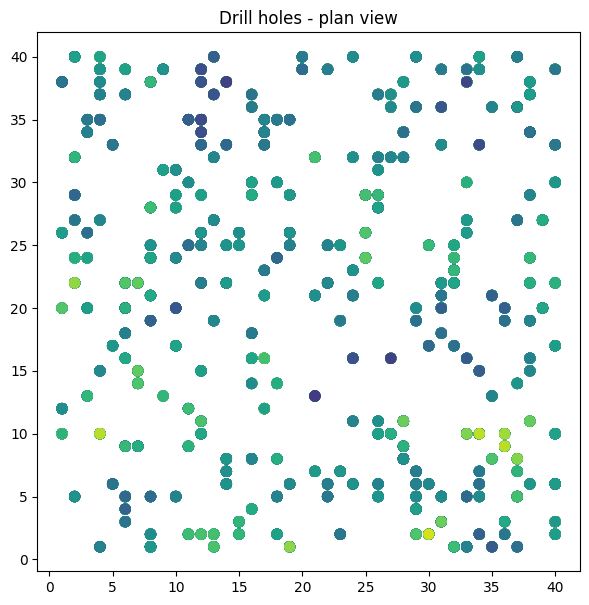

In [135]:
df_simulation = pd.read_csv('data/simulation_data.csv')

grid_size = max(df_simulation['x'].max(),df_simulation['y'].max(),df_simulation['y'].max())

numer_of_drillholes = 300

df_simulation[['x','y','z']] = df_simulation[['x','y','z']].astype(float)
x_y_grid = np.array(np.meshgrid(np.arange(1,grid_size+1,1), np.arange(1,grid_size+1,1))).T.reshape(-1,2)
df_simulation_sample = pd.DataFrame(columns=['x','y','z','finos'])
for item in np.random.default_rng().choice(x_y_grid,numer_of_drillholes):
    df_temp = df_simulation[(df_simulation['x']==item[0]) & (df_simulation['y']==item[1])]
    df_simulation_sample = pd.concat([df_temp, df_simulation_sample])

fig = plt.gcf()
fig.set_size_inches(7,7)
plt.scatter(df_simulation_sample['x'],df_simulation_sample['y'],
c=df_simulation_sample['finos'], marker='o', s=50)
plt.title('Drill holes - plan view')

### Creating a Multilayer perceptron to make predictions

#### Create Training Dataset

In [136]:
df_sample = pd.get_dummies(df_simulation_sample)
columns = df_sample.columns.tolist()
columns.remove('finos')
columns.append('finos')
df_sample = df_sample[columns]

df = pd.get_dummies(df_simulation)
columns = df.columns.tolist()
columns.remove('finos')
columns.append('finos')
df = df[columns]

sc = StandardScaler()
sc.fit(df[['x','y','z']])
df[['x','y','z']] = sc.transform(df[['x','y','z']])
df_sample[['x','y','z']] = sc.transform(df_sample[['x','y','z']])

### Using Pytorch

In [137]:
# Define la clase de la red neuronal
class MineralPredictionNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MineralPredictionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, int(hidden_size/2))
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(int(hidden_size/2), hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        # self.fc4 = nn.Linear(2*hidden_size, output_size)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        # out = self.relu(out)
        # out = self.fc4(out)
        return out

class Data(torch.utils.data.Dataset):
  def __init__(self, X: pd.DataFrame, y: pd.DataFrame, device) -> None:
    # need to convert float64 to float32 else
    # will get the following error
    # RuntimeError: expected scalar type Double but found Float
    self.X = torch.from_numpy(X.to_numpy().astype(np.float32)).to(device)
    self.y = torch.from_numpy(y.to_numpy().astype(np.float32)).to(device)
    self.len = self.X.shape[0]
  def __getitem__(self, index: int) -> tuple:
    return self.X[index], self.y[index]
  def __len__(self) -> int:
    return self.len

In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define el tamaño de entrada, oculto y salida de la red neuronal
X = df_sample.iloc[:,:-1]
y = df_sample.iloc[:,1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

train = Data(X_train, y_train,device)
val = Data(X_val, y_val,device)
real = Data(df.iloc[:,:-1],df.iloc[:,-1], device)

train_loader = data.DataLoader(train, batch_size=50)
val_loader = data.DataLoader(val, batch_size=50)
real_loader = data.DataLoader(real)

input_size = X.shape[1]  # 3 coordenadas XYZ y n_litologies litologías
hidden_size = 32
output_size = 1  # Ley mineral del yacimiento

# Inicializa la red neuronal
model = MineralPredictionNet(input_size, hidden_size, output_size)
model.to(device)

# Define la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [139]:
# Repite el proceso de entrenamiento y validación varias veces
epochs = 50
loss_list=[]
val_list = []
for epoch in range(epochs):
    # Itera a través de los datos de entrenamiento
    running_loss = 0
    running_val = 0
    for x, y in train_loader:
        # Predice la salida usando la red neuronal
        y_pred = model(x)
        y_pred = y_pred.squeeze()
        loss = criterion(y_pred, y)

        # Realiza el backpropagation y actualiza los parámetros
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss = running_loss + loss.item()
    loss_list.append(running_loss)

    # Itera a través de los datos de validación
    for x,y in val_loader:
        # Convierte los datos a tensores de PyTorch

        # Predice la salida usando la red neuronal
        y_pred = model(x)
        y_pred = y_pred.squeeze()

        # Calcula la pérdida
        val = criterion(y_pred, y)
        running_val = running_val + val.item()
    val_list.append(running_val)
    
      # display statistics
    print(f'epoch {epoch + 1}, loss {running_loss:f}')
    print(f'epoch {epoch + 1}, val {running_val:f}')

epoch 1, loss 58.395784
epoch 1, val 1.208827
epoch 2, loss 2.294011
epoch 2, val 0.284927
epoch 3, loss 0.840563
epoch 3, val 0.153286
epoch 4, loss 0.501486
epoch 4, val 0.103497
epoch 5, loss 0.355436
epoch 5, val 0.076501
epoch 6, loss 0.276678
epoch 6, val 0.059752
epoch 7, loss 0.224464
epoch 7, val 0.048864
epoch 8, loss 0.185254
epoch 8, val 0.040679
epoch 9, loss 0.154887
epoch 9, val 0.035007
epoch 10, loss 0.131373
epoch 10, val 0.031031
epoch 11, loss 0.113165
epoch 11, val 0.027484
epoch 12, loss 0.098089
epoch 12, val 0.023213
epoch 13, loss 0.085896
epoch 13, val 0.019600
epoch 14, loss 0.076403
epoch 14, val 0.016706
epoch 15, loss 0.068510
epoch 15, val 0.014797
epoch 16, loss 0.061766
epoch 16, val 0.013925
epoch 17, loss 0.055832
epoch 17, val 0.013321
epoch 18, loss 0.049957
epoch 18, val 0.011989
epoch 19, loss 0.044601
epoch 19, val 0.010331
epoch 20, loss 0.039883
epoch 20, val 0.008773
epoch 21, loss 0.035829
epoch 21, val 0.007889
epoch 22, loss 0.032655
epoch 

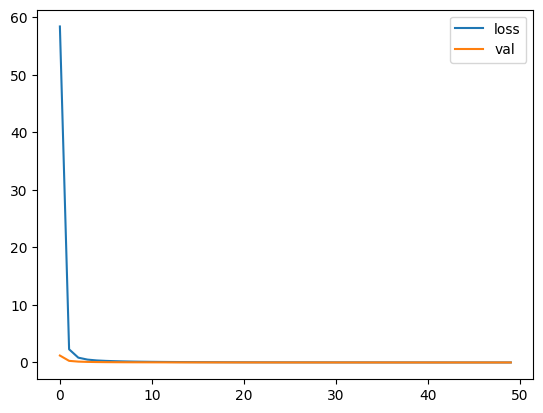

In [140]:
plt.plot(loss_list, label='loss')
plt.plot(val_list, label='val')
plt.legend()

r2:  -19.56839762270771
mae:  4.381932020705804
mape:  118875886715.88062


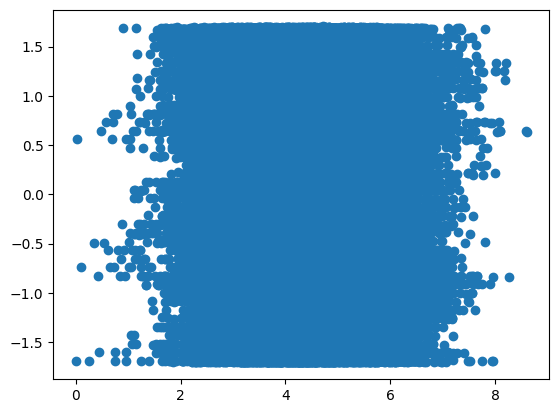

In [141]:
y_pred = []
y_real = []
for x,y in real_loader:
    i = i+1
    y_p = model(x)
    y_pred.append(y_p.item())
    y_real.append(y.item())

print("r2: ", r2_score(y_real, y_pred))
print("mae: ", mean_absolute_error(y_real, y_pred))
print("mape: ", mean_absolute_percentage_error(y_real, y_pred))
plt.scatter(y_real, y_pred)

### Using Tensorflow

In [142]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers

# Define el tamaño de entrada, oculto y salida de la red neuronal
X = df_sample.iloc[:,:-1]
y = df_sample.iloc[:,1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

def build_model():
    input_layer = layers.Input(shape=(X_train.shape[1],), name='input')
    first_dense = layers.Dense(units=25, activation='relu')(input_layer)
    second_dense = layers.Dense(units=625, activation='relu')(first_dense)
    third_dense = layers.Dense(units=1250, activation='relu')(second_dense)
    output = layers.Dense(units=1, name='out')(third_dense)

    return Model(inputs=input_layer, outputs=output)

model = build_model()

# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=tf.keras.metrics.MeanSquaredError(),
              )
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10)]              0         
                                                                 
 dense_12 (Dense)            (None, 25)                275       
                                                                 
 dense_13 (Dense)            (None, 625)               16250     
                                                                 
 dense_14 (Dense)            (None, 1250)              782500    
                                                                 
 out (Dense)                 (None, 1)                 1251      
                                                                 
Total params: 800,276
Trainable params: 800,276
Non-trainable params: 0
_________________________________________________________________


In [143]:
# Train the model for 200 epochs
history = model.fit(X_train, y_train,
                    epochs=50, batch_size=100, validation_data=(X_val, y_val))

Epoch 1/50
96/96 [==============================] - 1s 7ms/step - loss: 0.0450 - mean_squared_error: 0.0450 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 2/50
96/96 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 3/50
96/96 [==============================] - 0s 3ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 4/50
96/96 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 9.1679e-04 - val_mean_squared_error: 9.1679e-04
Epoch 5/50
96/96 [==============================] - 0s 3ms/step - loss: 7.5333e-04 - mean_squared_error: 7.5333e-04 - val_loss: 6.2231e-04 - val_mean_squared_error: 6.2231e-04
Epoch 6/50
96/96 [==============================] - 0s 3ms/step - loss: 5.6431e-04 - mean_squared_error: 5.6431e-04 - val_loss: 5.5245e-04 - val_mean_squared_error: 5.5245e-04


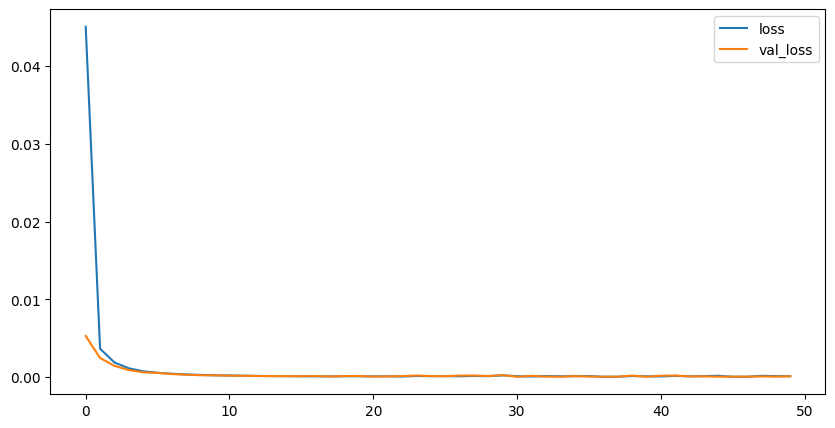

In [144]:
fig, axs = plt.subplots()
fig.set_size_inches(10,5)
axs.plot(history.history['loss'], label="loss")
axs.plot(history.history['val_loss'], label="val_loss")
axs.legend()

In [145]:
y_pred = model.predict(df.iloc[:,:-1])
y_real = df.iloc[:,-1]
print("r2: ", r2_score(y_real, y_pred))
print("mae: ", mean_absolute_error(y_real, y_pred))
print("mape: ", mean_absolute_percentage_error(y_real, y_pred))

2000/2000 [==============================] - 2s 1ms/step
r2:  -19.56971896916488
mae:  4.3823525242526
mape:  118819330720.74472
